In [1]:
from matplotlib import pyplot as plt

from jwave.geometry import Domain
from jwave import operators as jops
from jwave.core import operator
from jax import numpy as jnp
import jax

# Bio-heat equation

We want to solve

$$
\nabla^2 u = s
$$

in 2D. We further assume zero Dirichlet boundary conditions (uninsulated).

In [2]:
from jwave.primitives import Primitive

class FFTLaplacian(Primitive):
    def __init__(self, real=False, name="FFTLaplacian", independent_params=False):
        super().__init__(name, independent_params)
        self.real = real

    def setup(self, field):
        new_discretization = field.discretization
        k_vec = field.discretization._freq_axis
        parameters = {"k_vec": k_vec}
        return parameters, new_discretization

    def discrete_transform(self):
        if self.real:
            ffts = [jnp.fft.rfft, jnp.fft.irfft]
        else:
            ffts = [jnp.fft.fft, jnp.fft.ifft]

        def f(op_params, field_params):
            k_vec = op_params["k_vec"]
            u = field_params[..., 0]
            ndim = len(field_params.shape) - 1

            def single_grad(axis, u):
                u = jnp.moveaxis(u, axis, -1)
                Fx = ffts[0](u, axis=-1)
                iku = - Fx * k_vec[axis]**2
                du = ffts[1](iku, axis=-1, n=u.shape[-1])
                return jnp.moveaxis(du, -1, axis)

            return jnp.sum(jnp.stack([single_grad(i, u) for i in range(ndim)], axis=-1), axis=-1, keepdims=True)

        f.__name__ = self.name

        return f

In [16]:
domain = Domain((128,128), (1., 1.))

# This is not the optimal FFT laplacian. Should add a new primitive
def laplacian(u):
    return jops.sum_over_dims(jops.diag_jacobian(jops.gradient(u)))

fast_laplacian = FFTLaplacian(real=True)

@operator()
def heat_eq(u):
    return fast_laplacian(u)

In [27]:
from jwave.discretization import RealFourierSeries
from jwave.core import Field

# Initialize discretizations
fourier_discr = RealFourierSeries(domain)

# Initialize parameters (we already have the PML parameters)
u_fourier_params = fourier_discr.empty_field()
src_fourier_params = u_fourier_params.at[32:36,32:42].set(1.)  # Source field, using Fourier discretization

# Create fields
u = Field(fourier_discr, params=u_fourier_params, name='u')
src = Field(fourier_discr, params=src_fourier_params, name='src')

In [28]:
Hu = heat_eq(u=u)

print(Hu)

DiscretizedOperator :: [RealFourierSeries], ['_k5'] 

 Input fields: ('u',)

Globals: {'shared': {'FFTLaplacian': {'k_vec': [DeviceArray([0.        , 0.04908739, 0.09817477, 0.14726216, 0.19634955,
             0.24543694, 0.2945243 , 0.34361172, 0.3926991 , 0.44178647,
             0.49087387, 0.5399613 , 0.5890486 , 0.638136  , 0.68722343,
             0.7363108 , 0.7853982 , 0.8344856 , 0.88357294, 0.93266034,
             0.98174775, 1.0308352 , 1.0799226 , 1.1290098 , 1.1780972 ,
             1.2271847 , 1.276272  , 1.3253595 , 1.3744469 , 1.4235342 ,
             1.4726216 , 1.521709  , 1.5707964 , 1.6198838 , 1.6689712 ,
             1.7180586 , 1.7671459 , 1.8162333 , 1.8653207 , 1.9144081 ,
             1.9634955 , 2.0125828 , 2.0616703 , 2.1107576 , 2.159845  ,
             2.2089324 , 2.2580197 , 2.3071072 , 2.3561945 , 2.405282  ,
             2.4543693 , 2.5034568 , 2.552544  , 2.6016314 , 2.650719  ,
             2.6998062 , 2.7488937 , 2.797981  , 2.8470683 , 2.8961558 ,

In [29]:
# Make the computational graph
Hu = heat_eq(u=u)
global_params = Hu.get_global_params()

# hack to force BC using padding
small_src = src_fourier_params[1:-1,1:-1,:]
@jax.jit
def heat_func(u):
    u = jnp.pad(u,((1,1),(1,1),(0,0)))
    
    f = Hu.get_field_on_grid(0)
    
    op_image = f(
        global_params,
        {"u":u}
    )
    
    return op_image[1:-1,1:-1,:]

In [30]:
from jax.scipy.sparse.linalg import gmres
from functools import partial

sol, _ = gmres(heat_func, -small_src, maxiter=1000, restart=25)

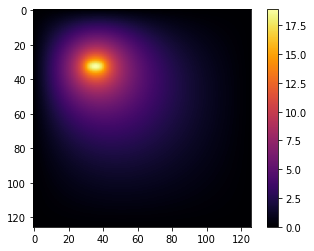

In [31]:
plt.imshow(sol, cmap="inferno", vmin=0.)
plt.colorbar()